# USING CIRCULAR MAPPING FOR EFFICIENT MULTI-QUBIT GATE TRANSPILATIONS

## Authors
* Quentin Ruiz
* Rohan Srikumar
* Kilian Teck
* Dimitrios Diplaris
* Kerem Yurtseven

## Contents:
* [Linear vs Circular Connection](#linearvscircular)
* [Adaptive Cyclic Layout Mapping (ACLM)](#ACLM)
* [Benchmarking](#benchmarking)
* [Generalizing to Disordered Multi-Qubit Gates](#generalizing-to-disordered-multi-qubit-gates)

## Linear vs Circular Connection <a class="anchor" id="linearvscircular"></a>

![Circularly Connected Qubits vs Linearly Connected Qubits](q0.png "Circular vs Linear")

2-qubit gates are one of the most fundamental blocks of quantum algorithms, and we encounter repeated patterns of 2-qubit gates in most of the algorithms. For example, to realize an variational ansatz for VQE, we need repeatedly connected CX gates between qubits either linearly, circular, or even fully.

On the other hand, they are one of the most compulsory part of transpilation due to limited connection of real quantum devices. It requieres a considered methodology to both decrease SWAP gates and increase the fidelity of 2-qubit gates.

Linearly applied CX gates, as shown below, are straightforward to transpile in terms of mapping from virtual qubits to physical qubits. One can intuitively come up with the idea of mapping each qubit to device such that they constitute a continous line. One can also think that circularly applied CX gates can be mapped in a similar manner; however, mapping algorithms does not give this result most of the times

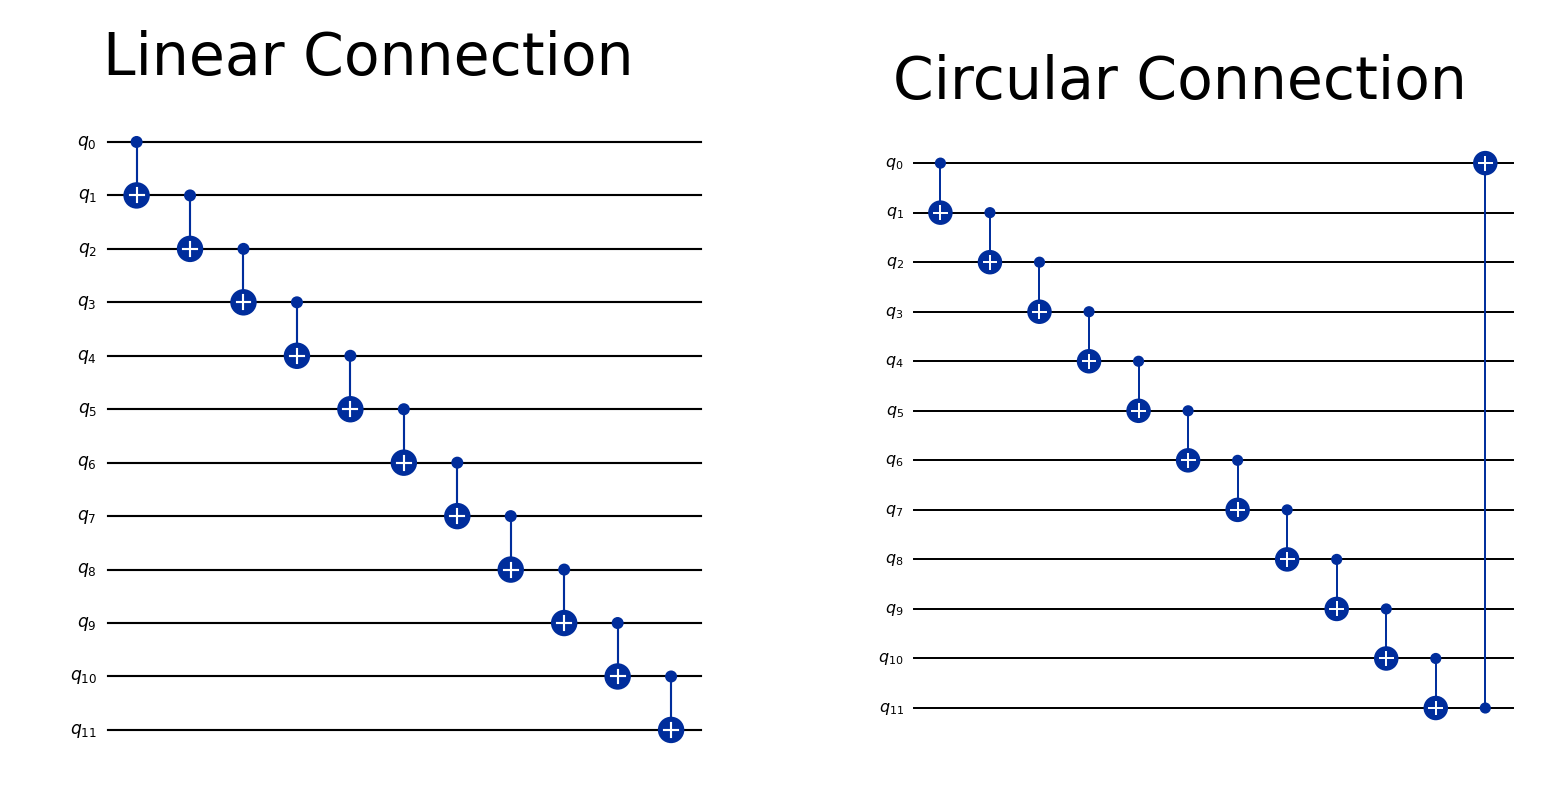

In [114]:
import qiskit
import matplotlib.pyplot as plt
# Transpilation seed for consistency
SEED = 10

# Create a linearly connected circuit with repeated cx gates
qc_linear = qiskit.QuantumCircuit(12)
for i in range(0,11):
    qc_linear.cx(i,i+1)

# Create a circularly connected circuit with repeated cx gates
qc_circular = qiskit.QuantumCircuit(12)
for i in range(0,11):
    qc_circular.cx(i,i+1)
qc_circular.cx(11,0)

fig, axs = plt.subplots(nrows=1, ncols=2, dpi=300)
axs[0].set_title("Linear Connection")
qc_linear.draw("mpl", ax=axs[0])
axs[1].set_title("Circular Connection")
qc_circular.draw("mpl", ax=axs[1])

In [115]:
import qiskit.transpiler
import qiskit.visualization
import qiskit_ibm_runtime

# Create a backend imitating a real quantum hardware
backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()

# A generic pass manager to illustrate layouts of above circuits
pm = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

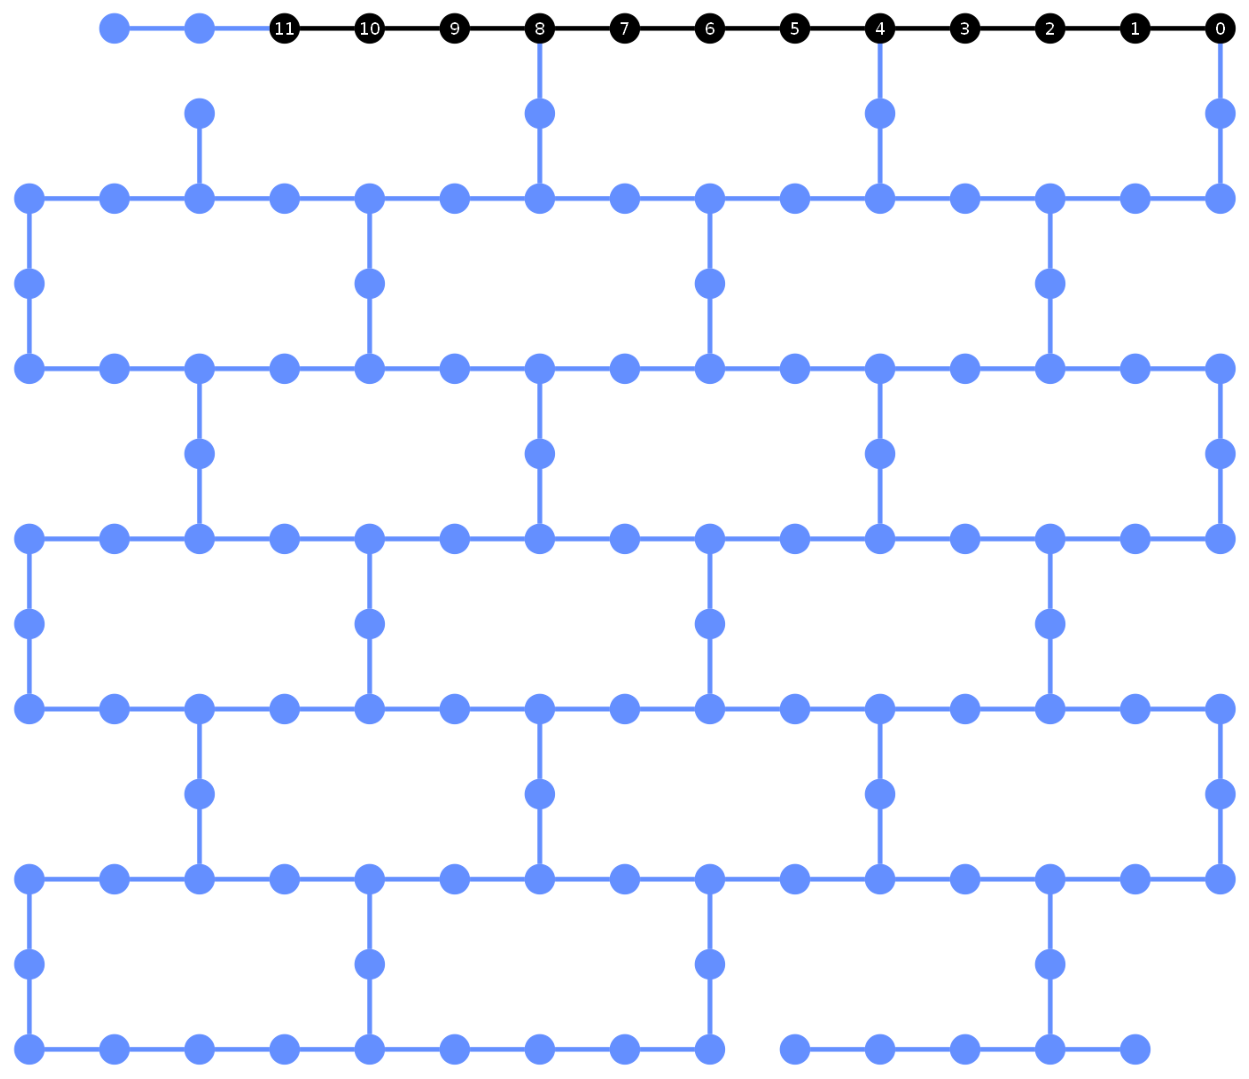

In [116]:
# Linear layout
isa_circuit_linear = pm.run(qc_linear)
qiskit.visualization.plot_circuit_layout(isa_circuit_linear, backend)

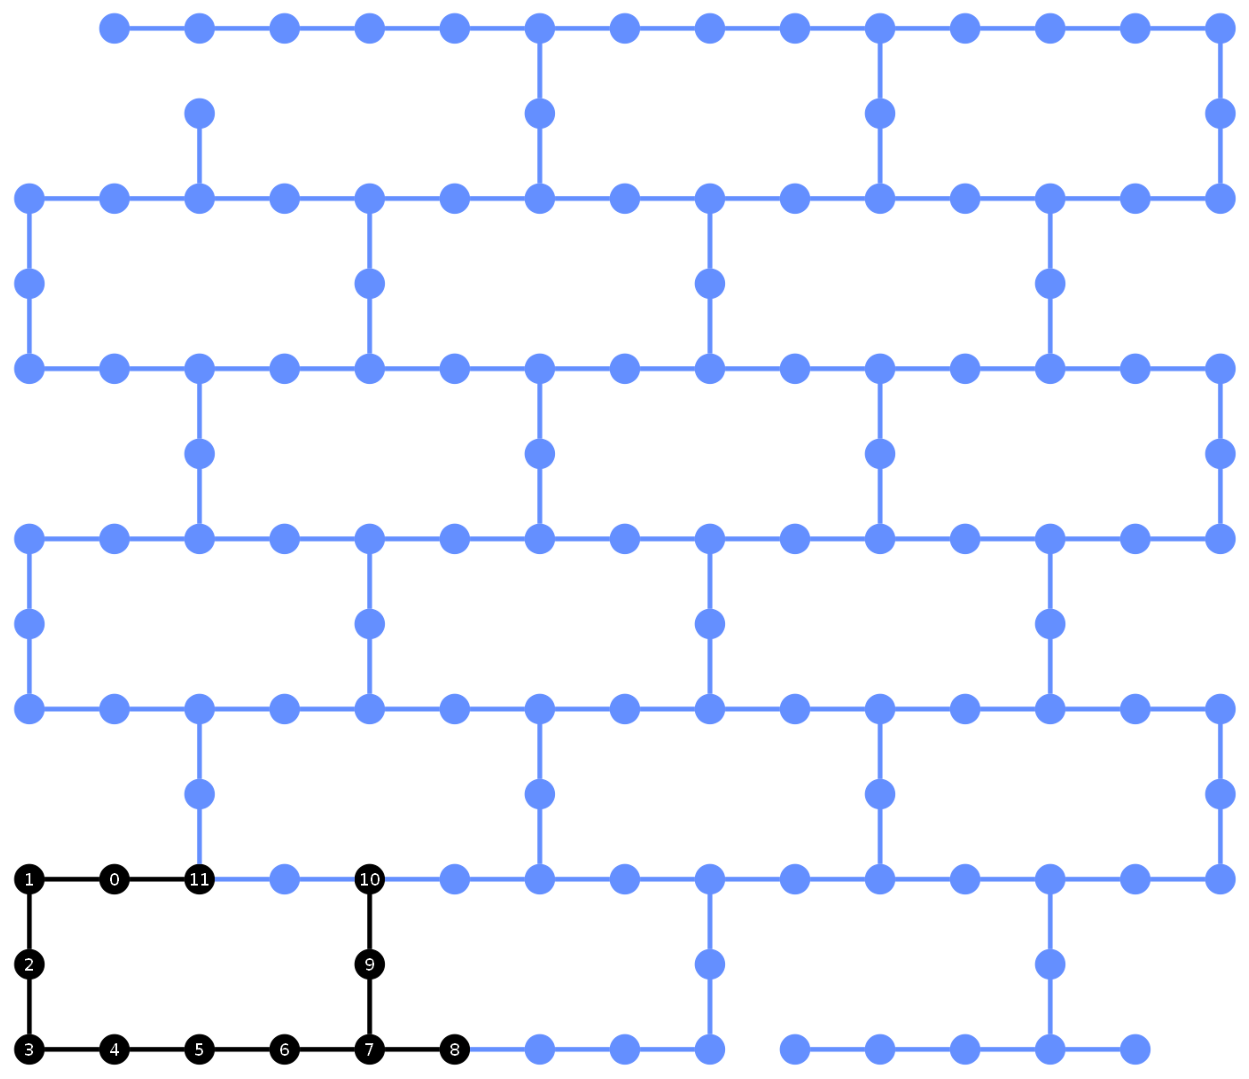

In [117]:
# Circular layout
isa_circuit_circular = pm.run(qc_circular)
qiskit.visualization.plot_circuit_layout(isa_circuit_circular, backend)

**We assert that circular mapping is more efficient in terms of circuit depth, 2-qubit count, and error mitigation**

## Adaptive Cyclic Layout Mapping (ACLM) <a class="anchor" id="ACLM"></a>

In order to find a circular mapping or similar-to-circular mapping, we analyze the structure of the backend and find most optimal ways using [NetworkX](https://networkx.org/documentation/stable/tutorial.html). Due to layout of backends, it is not possible find a circle for each length, number of qubits, yet it is still possible to obtain a mapping similar to a circle and become more efficient than naive Qiskit methodologies.

In [118]:
import networkx as nx
from qiskit.transpiler import Layout, CouplingMap

In [119]:
def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Find exact cycle of length n, else nearest larger cycle.
    """
    G = nx.Graph()
    G.add_edges_from(coupling_map.get_edges())
    cycles = list(nx.cycle_basis(G))

    exact = [c for c in cycles if len(c) == n]
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):
    """
    Adaptive layout for ring circuits with ancilla if needed.
    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits
    
    return required_qubits, ancilla

We are going to use the function "RealAmplitudes()" to create cyclic CX gates that are used to constitute variational ansatz circuits.

In [120]:
cm = CouplingMap(backend.configuration().coupling_map)

# Determine layout and qubits. Even though the aim is using n qubits, sometimes it may be more efficient to use more than n qubits with the help of ancilla qubits
required_qubits, ancilla_count = adaptive_ring_layout(12, cm)

# Insteaf of n=12, we use required_qubits since we want full cycles
qc_cyclic= qiskit.circuit.library.RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)

# Obtain cycle-graph with circuit + ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

# Create the layout mapping for the backend
layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
layout_cyclic = Layout(layout_dict)

Depth:  20
CNOT count:  12


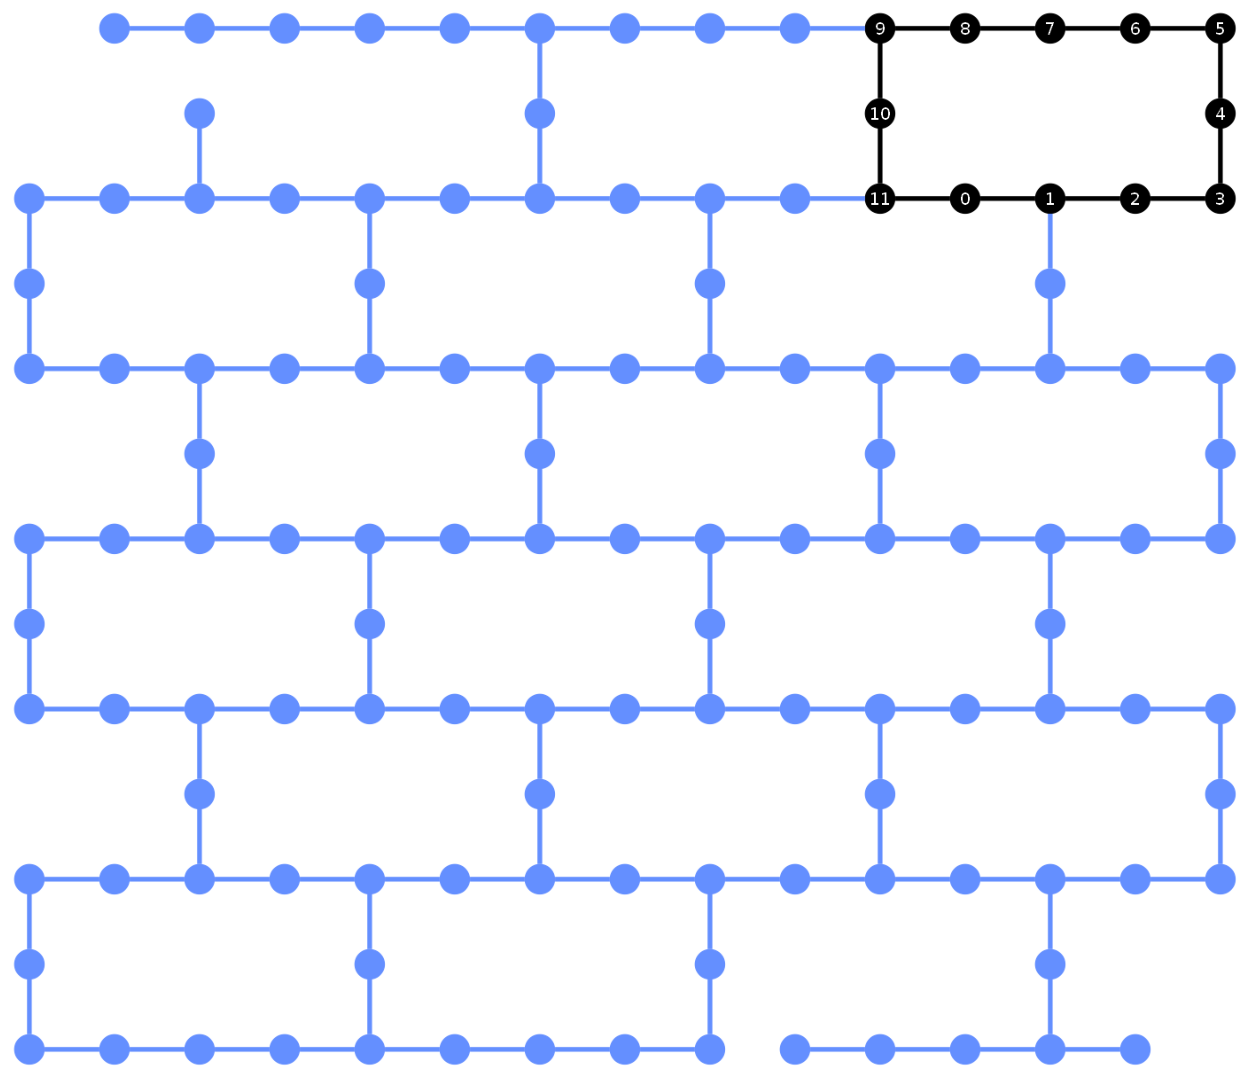

In [121]:
# Creating the pass manager with special layout mapping
pass_manager = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)
    
circularly_transpiled_circuit = pass_manager.run(qc_cyclic)

print("Depth: ", circularly_transpiled_circuit.depth())
print("CNOT count: ", circularly_transpiled_circuit.count_ops().get("cx", 0))
qiskit.visualization.plot_circuit_layout(circularly_transpiled_circuit, backend)

In order to compare, we transpile same circuit with "Sabre" method

Depth:  30
CNOT count:  18


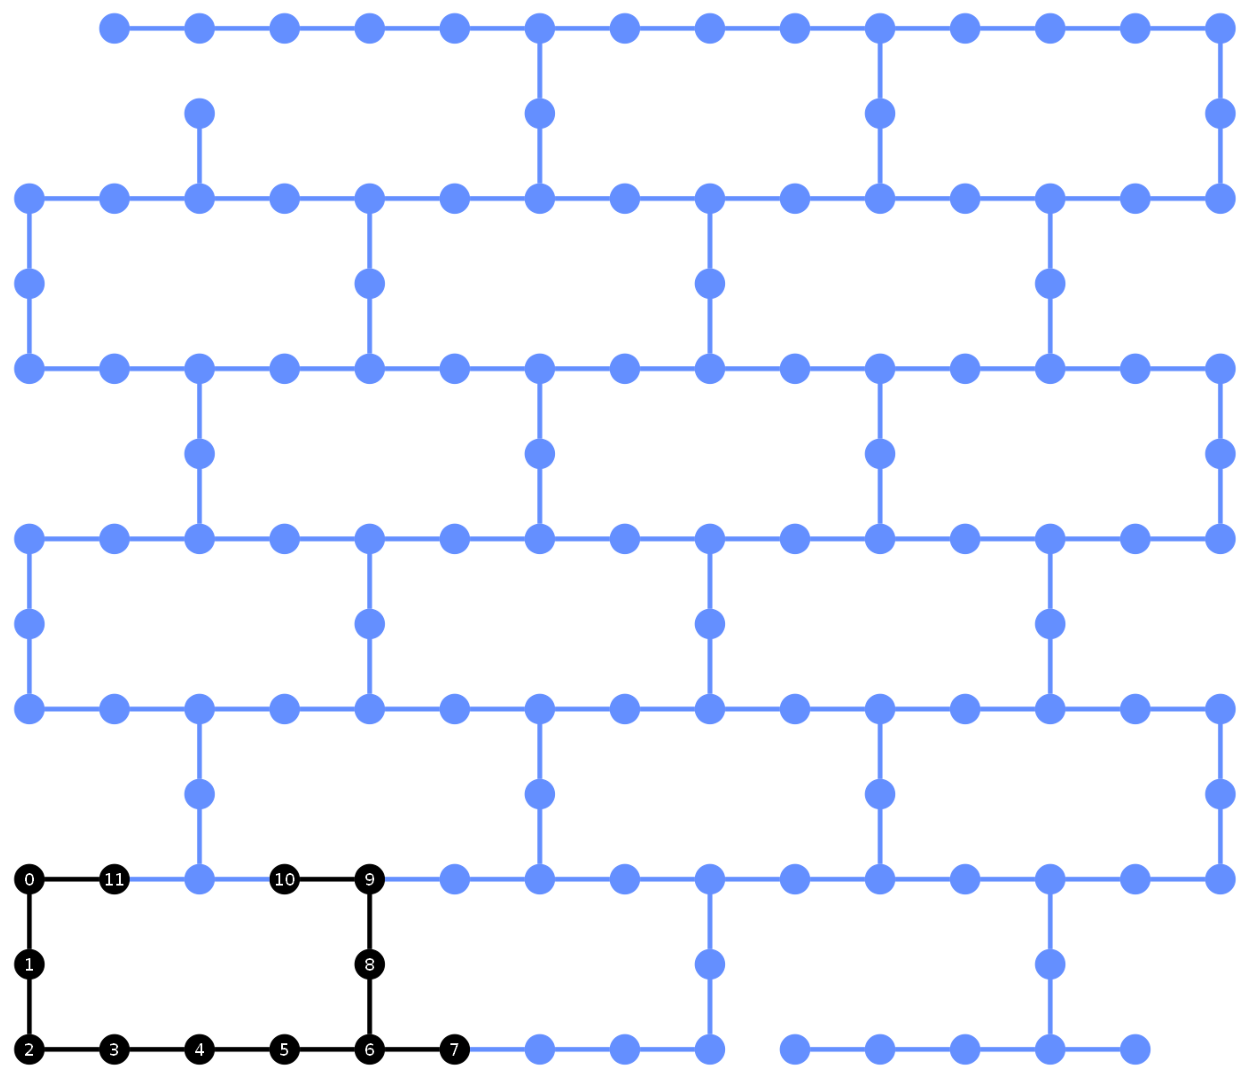

In [122]:
qc = qiskit.circuit.library.RealAmplitudes(num_qubits=12, reps=1, entanglement='circular', flatten=True)

pass_manager = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='sabre',
        seed_transpiler=SEED)
    
sabre_transpiled_circuit = pass_manager.run(qc)

print("Depth: ", sabre_transpiled_circuit.depth())
print("CNOT count: ", sabre_transpiled_circuit.count_ops().get("cx", 0))
qiskit.visualization.plot_circuit_layout(sabre_transpiled_circuit, backend)

As one can see, even for such a small circuit there exists a difference of **10 in depth and 6 in CNOT gates.**

**Example Case: Variational Ansatz Circuit with 25 Qubits**

In [123]:
backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

n = 16 # Number of qubits

required_qubits, ancilla_count = adaptive_ring_layout(n, cm)

# Full circular layout circuit
qc_cyclic= qiskit.circuit.library.RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)
# Original circuit
qc = qiskit.circuit.library.RealAmplitudes(num_qubits=n, reps=1, entanglement='circular', flatten=True)

# Obtain cycle-graph with circuit + ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

# Layout mapping for circular mapping
layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
layout_cyclic = Layout(layout_dict)

# Layout mapping for similar-to-circular mapping
layout_dict = {qc.qubits[i]: cycle[i] for i in range(n)}
layout_approx = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for Circular layout
pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

# Pass manager for Similar-to-circular layout
pass_manager_approx = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_approx,
        seed_transpiler=SEED)

sabre_transpiled_circuit = pass_manager_sabre.run(qc)
circularly_transpiled_circuit = pass_manager_cycle.run(qc_cyclic)
approx_transpiled_circuit = pass_manager_approx.run(qc)

print("Depth (Sabre | Circle | Approximate): ", sabre_transpiled_circuit.depth(), " | ", circularly_transpiled_circuit.depth(), " | ", approx_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle | Approximate): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", circularly_transpiled_circuit.count_ops().get("cx", 0), " | ", approx_transpiled_circuit.count_ops().get("cx", 0))

Depth (Sabre | Circle | Approximate):  34  |  28  |  39
CNOT count (Sabre | Circle | Approximate):  34  |  20  |  40


| | Sabre | Circle | Approximate |
| --- | --- | --- | --- |
| Depth | 44 | 28 | 42 |
| CNOT Count | 28 | 20 | 40 |

That shows both full circle and approximately circle layout mappings are more efficient than Qiskit naive methods in terms of depth and CNOT gate count. Even though full circle is the best mapping, in case of simulating periodic Hamiltonians (using QAOA for example), adding further ancilla qubits will change the cost Hamiltonian.

However, one can still find the smallest cyclic sub-graph that is larger than the given circuit and then choose to map it partially.

Such an approach will minimize the distance between the first and last qubits, reducing the SWAP gate overhead

## Benchmarking <a class="anchor" id="benchmarking"></a>

**Number of Qubits vs Circuit Depth & CNOT Gate Count for Different Layouts**

We will compare Qiskit methods for layout, namely "Sabre", "Trivial", and "Dense" to our proposals "Full Circle" and "Approximate" using "RealAmplitudes()" circuits

In [124]:
# Different number of qubits
n_s = [6,9,12,15,18,20,25,30,50,65]

depth_s = {"sabre":[], "trivial":[], "dense":[], "full":[], "approx":[]}
cnot_s = {"sabre":[], "trivial":[], "dense":[], "full":[], "approx":[]}

backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Creating transpilers for Qiskit methods
pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='sabre',
        coupling_map=cm,
        seed_transpiler=SEED)

pass_manager_trivial = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='trivial',
        coupling_map=cm,
        seed_transpiler=SEED)

pass_manager_dense = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='dense',
        coupling_map=cm,
        seed_transpiler=SEED)

for n in n_s:
        # Calculating the condition for full circle
        required_qubits, ancilla_count = adaptive_ring_layout(n, cm)

        # Possibly not-full circle circuit
        qc= qiskit.circuit.library.RealAmplitudes(num_qubits=n, reps=1, entanglement='circular', flatten=True)
        # Full circle circuit
        qc_cyclic= qiskit.circuit.library.RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)

        # Transpile and save Qiskit methods
        transpiled_sabre = pass_manager_sabre.run(qc)
        transpiled_trivial = pass_manager_trivial.run(qc)
        transpiled_dense = pass_manager_dense.run(qc)

        depth_s["sabre"].append(transpiled_sabre.depth())
        cnot_s["sabre"].append(transpiled_sabre.count_ops().get("cx", 0))

        depth_s["trivial"].append(transpiled_trivial.depth())
        cnot_s["trivial"].append(transpiled_trivial.count_ops().get("cx", 0))

        depth_s["dense"].append(transpiled_dense.depth())
        cnot_s["dense"].append(transpiled_dense.count_ops().get("cx", 0))

        # Find the best cycle for our methods
        cycle = find_best_cycle(cm, required_qubits)

        # Find the layout and transpile the full circle circuit
        layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
        layout_cyclic = Layout(layout_dict)

        pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

        transpiled_full = pass_manager_cycle.run(qc_cyclic)

        # Find the layout and transpile the approximate circuit
        layout_dict = {qc.qubits[i]: cycle[i] for i in range(n)}
        layout_approx = Layout(layout_dict)
        pass_manager_approx = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=2,
                backend=backend,
                initial_layout=layout_approx,
                seed_transpiler=SEED)
        
        transpiled_approx = pass_manager_approx.run(qc)

        depth_s["full"].append(transpiled_full.depth())
        cnot_s["full"].append(transpiled_full.count_ops().get("cx", 0))

        depth_s["approx"].append(transpiled_approx.depth())
        cnot_s["approx"].append(transpiled_approx.count_ops().get("cx", 0))

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Preset for plots
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 15,
    "figure.titlesize": 14,
    "lines.linewidth": 3,
    "lines.markersize": 8,
    "axes.grid": True,
    "axes.grid.which": "both",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.7,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.linewidth": 1.2,
    "legend.frameon": True,
    "legend.framealpha": 0.8,
    "legend.fancybox": True,
    "legend.loc": "best",
    "font.size": 25,
})

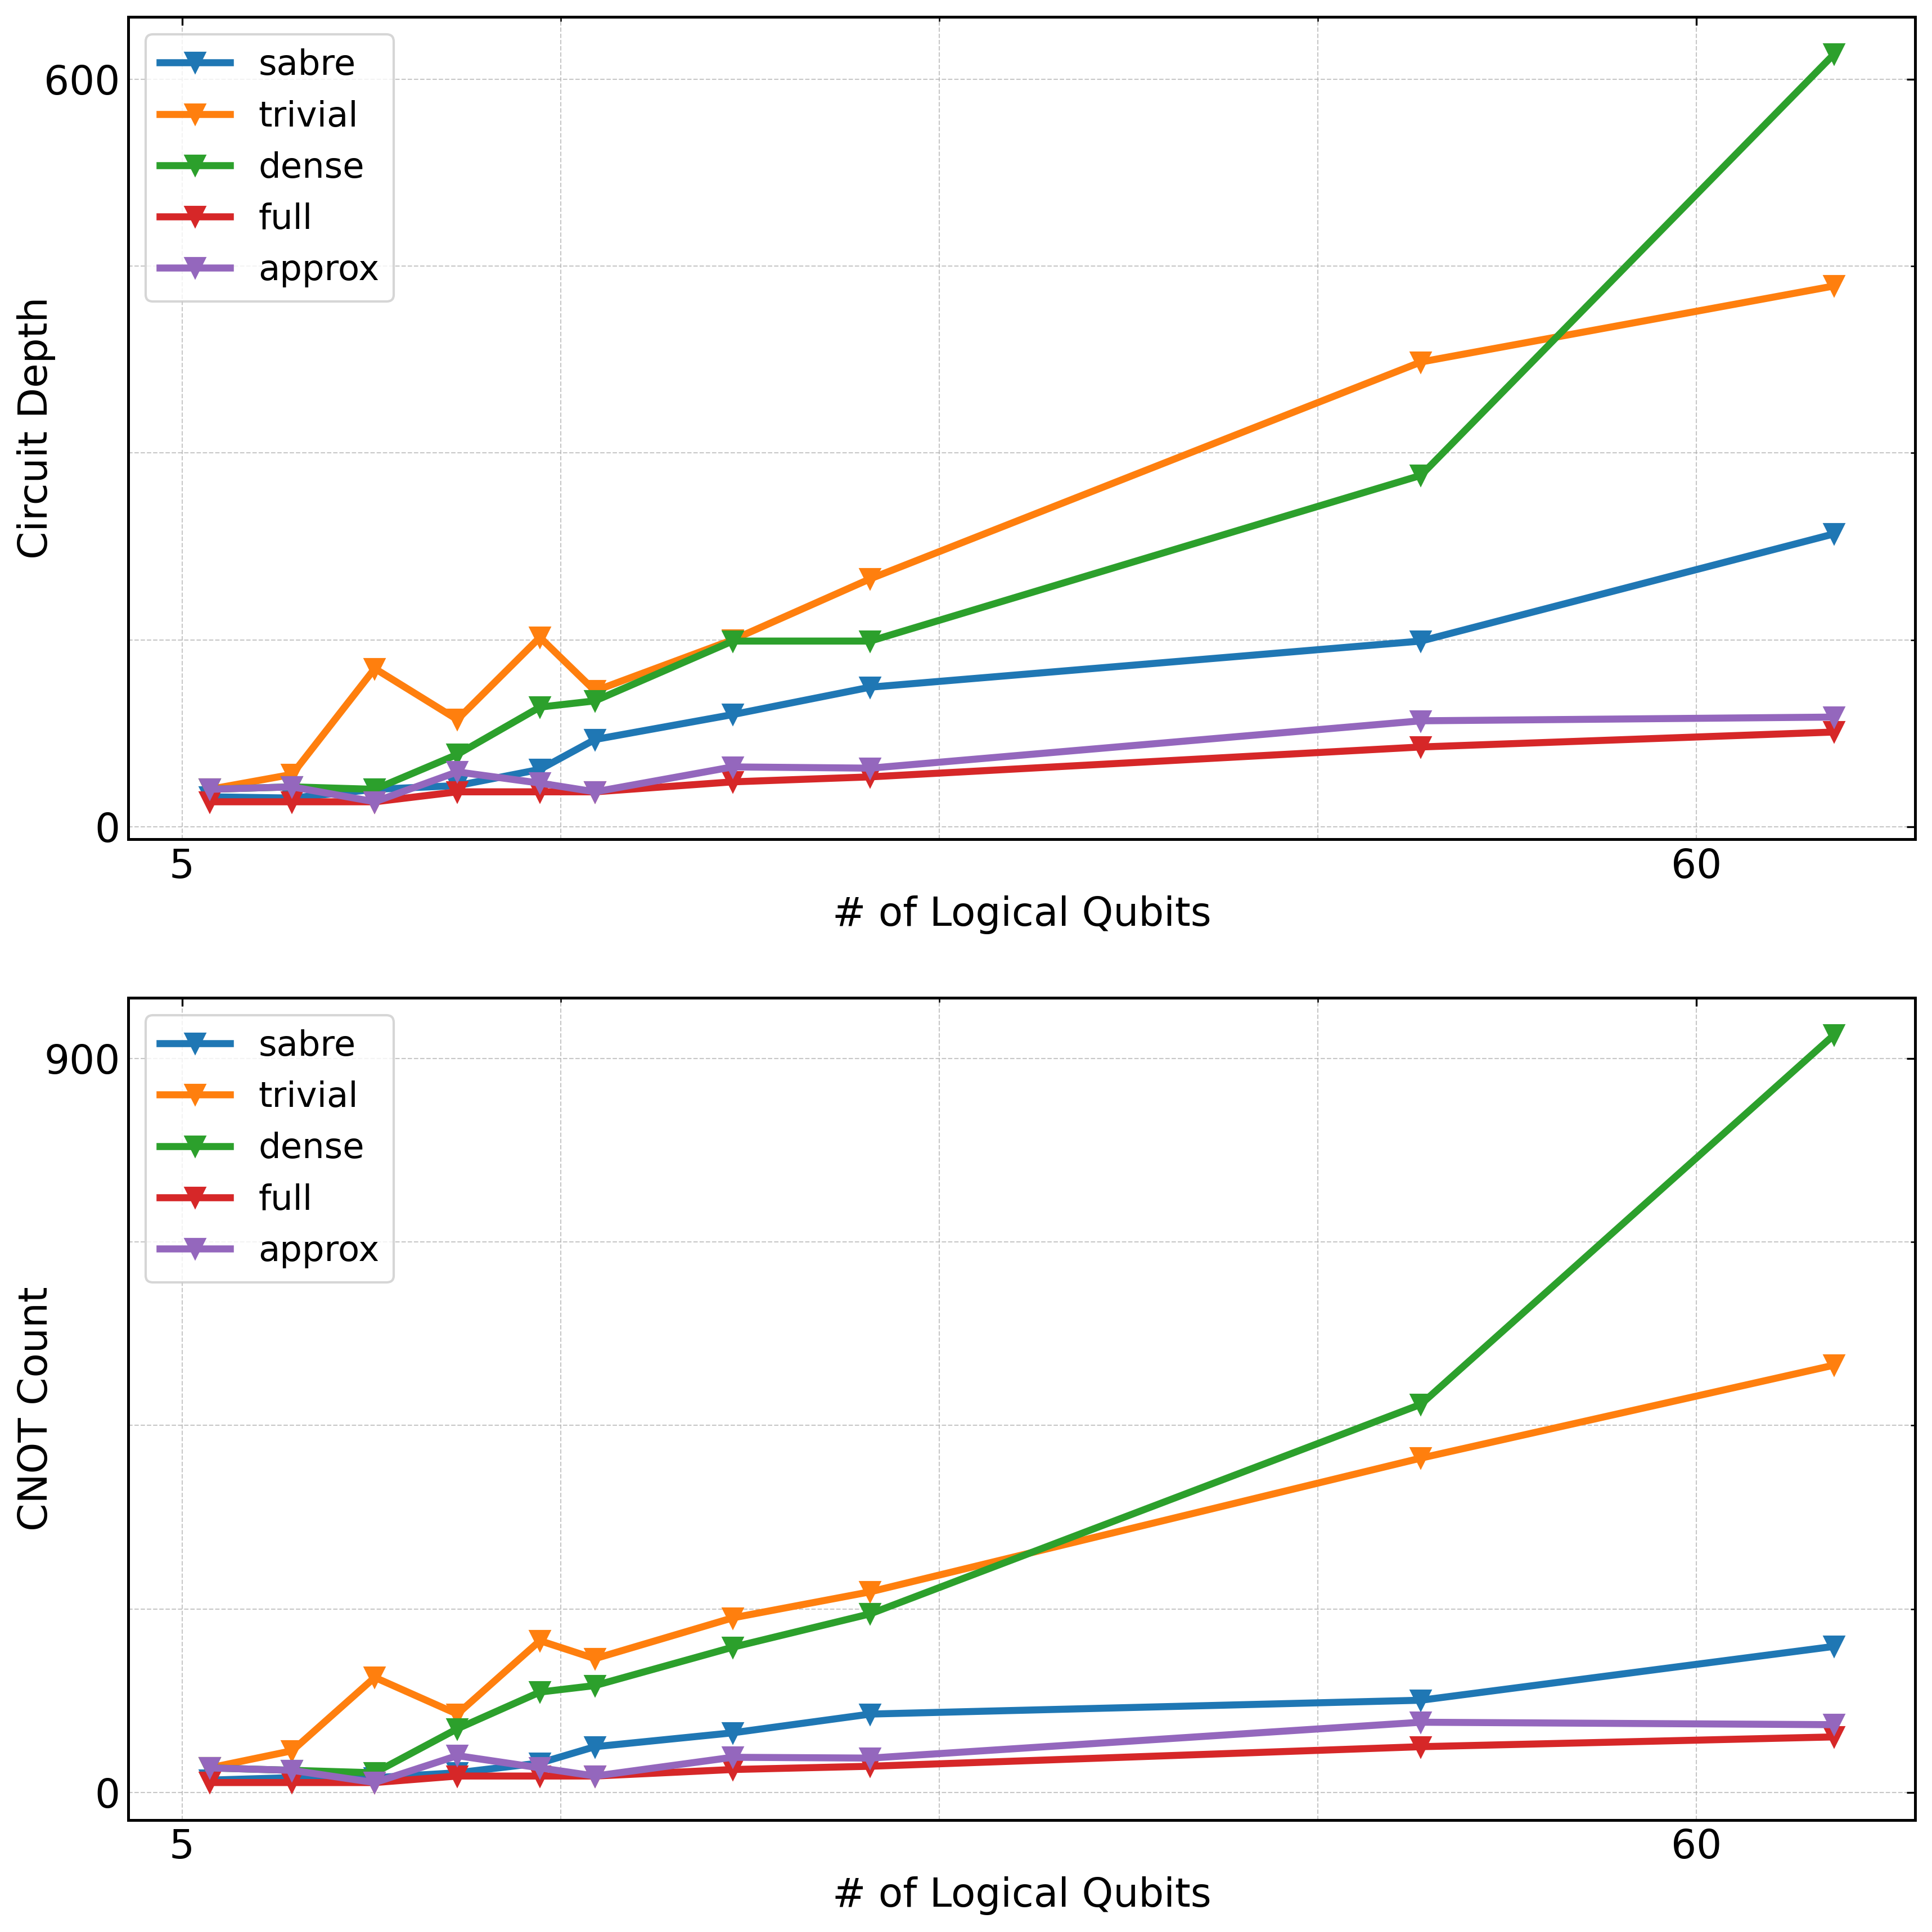

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,12), dpi=300)
ax = axs[0]
ax.plot(n_s, depth_s["sabre"], "v-", label="sabre")
ax.plot(n_s, depth_s["trivial"], "v-", label="trivial")
ax.plot(n_s, depth_s["dense"], "v-", label="dense")
ax.plot(n_s, depth_s["full"], "v-", label="full")
ax.plot(n_s, depth_s["approx"], "v-", label="approx")
# Logical qubits is used to mention n, full circle circuits are also plotted based on n, not required_qubits
ax.set_xlabel('# of Logical Qubits')
ax.set_ylabel('Circuit Depth', labelpad=-5)
ax.set_xticks(np.array([5, 60]))
ax.set_yticks(np.array([0, 600]))
ax.legend()

ax = axs[1]
ax.plot(n_s, cnot_s["sabre"], "v-", label="sabre")
ax.plot(n_s, cnot_s["trivial"], "v-", label="trivial")
ax.plot(n_s, cnot_s["dense"], "v-", label="dense")
ax.plot(n_s, cnot_s["full"], "v-", label="full")
ax.plot(n_s, cnot_s["approx"], "v-", label="approx")
# Logical qubits is used to mention n, full circle circuits are also plotted based on n, not required_qubits
ax.set_xlabel('# of Logical Qubits')
ax.set_ylabel('CNOT Count', labelpad=-5)
ax.set_xticks(np.array([5, 60]))
ax.set_yticks(np.array([0, 900]))
ax.legend()
plt.tight_layout()

**Optimization Level vs Circuit Depth & CNOT Gate Count for Different Layouts**

In [127]:
# Set n to 25 and creat optimization levels
opt_s = [0,1,2,3]
n = 25

depth_s = {"sabre":[], "trivial":[], "dense":[], "full":[], "approx":[]}
cnot_s = {"sabre":[], "trivial":[], "dense":[], "full":[], "approx":[]}

backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

for o in opt_s:
        # Creating transpilers for Qiskit methods
        pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=o,
                backend=backend,
                layout_method='sabre',
                coupling_map=cm,
                seed_transpiler=SEED)

        pass_manager_trivial = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=o,
                backend=backend,
                layout_method='trivial',
                coupling_map=cm,
                seed_transpiler=SEED)

        pass_manager_dense = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=o,
                backend=backend,
                layout_method='dense',
                coupling_map=cm,
                seed_transpiler=SEED)

        # Calculating the condition for full circle
        required_qubits, ancilla_count = adaptive_ring_layout(n, cm)

        # Possibly not-full circle circuit
        qc= qiskit.circuit.library.RealAmplitudes(num_qubits=n, reps=1, entanglement='circular', flatten=True)
        # Full circle circuit
        qc_cyclic= qiskit.circuit.library.RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)

        # Transpile and save Qiskit methods
        transpiled_sabre = pass_manager_sabre.run(qc)
        transpiled_trivial = pass_manager_trivial.run(qc)
        transpiled_dense = pass_manager_dense.run(qc)

        depth_s["sabre"].append(transpiled_sabre.depth())
        cnot_s["sabre"].append(transpiled_sabre.count_ops().get("cx", 0))

        depth_s["trivial"].append(transpiled_trivial.depth())
        cnot_s["trivial"].append(transpiled_trivial.count_ops().get("cx", 0))

        depth_s["dense"].append(transpiled_dense.depth())
        cnot_s["dense"].append(transpiled_dense.count_ops().get("cx", 0))

        # Find the best cycle for our methods
        cycle = find_best_cycle(cm, required_qubits)

        # Find the layout and transpile the full circle circuit
        layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
        layout_cyclic = Layout(layout_dict)

        pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=o,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

        transpiled_full = pass_manager_cycle.run(qc_cyclic)

        # Find the layout and transpile the approximate circuit
        layout_dict = {qc.qubits[i]: cycle[i] for i in range(n)}
        layout_approx = Layout(layout_dict)
        pass_manager_approx = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=o,
                backend=backend,
                initial_layout=layout_approx,
                seed_transpiler=SEED)
        
        transpiled_approx = pass_manager_approx.run(qc)

        depth_s["full"].append(transpiled_full.depth())
        cnot_s["full"].append(transpiled_full.count_ops().get("cx", 0))

        depth_s["approx"].append(transpiled_approx.depth())
        cnot_s["approx"].append(transpiled_approx.count_ops().get("cx", 0))

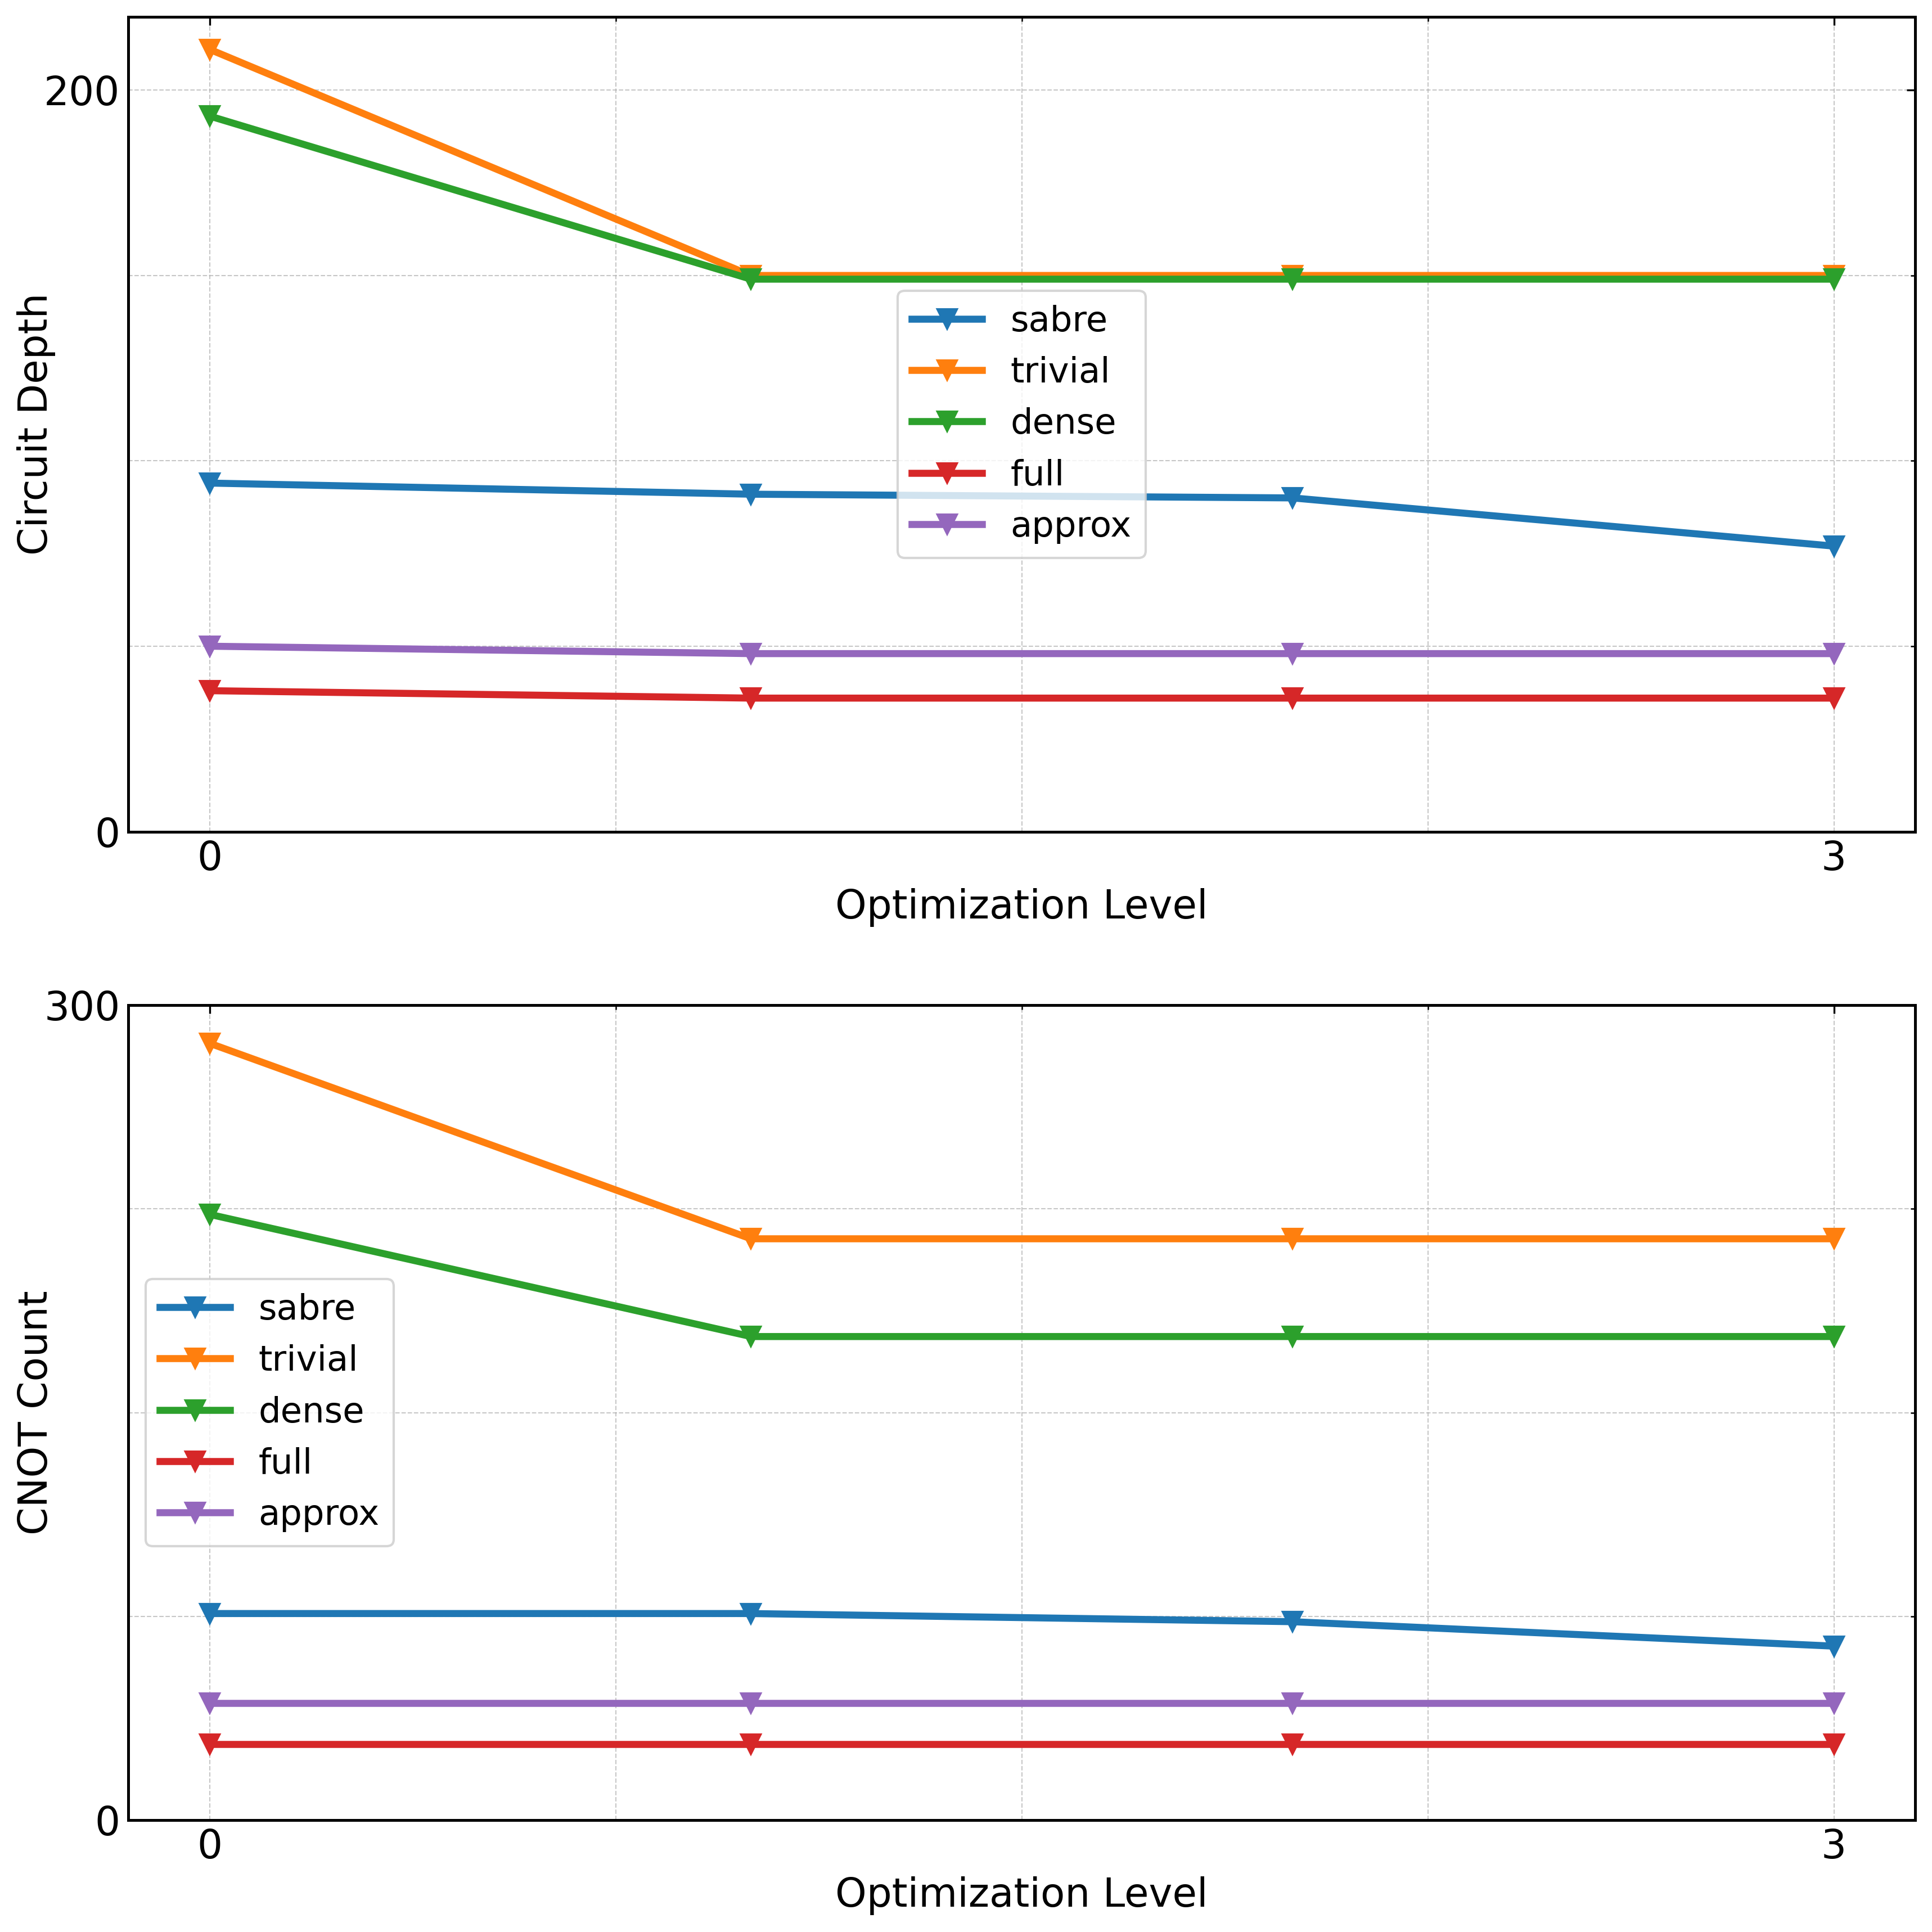

In [128]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,12), dpi=300)
ax = axs[0]
ax.plot(opt_s, depth_s["sabre"], "v-", label="sabre")
ax.plot(opt_s, depth_s["trivial"], "v-", label="trivial")
ax.plot(opt_s, depth_s["dense"], "v-", label="dense")
ax.plot(opt_s, depth_s["full"], "v-", label="full")
ax.plot(opt_s, depth_s["approx"], "v-", label="approx")
ax.set_xlabel('Optimization Level')
ax.set_ylabel('Circuit Depth', labelpad=-5)
ax.set_xticks(np.array([0, 3]))
ax.set_yticks(np.array([0, 200]))
ax.legend()

ax = axs[1]
ax.plot(opt_s, cnot_s["sabre"], "v-", label="sabre")
ax.plot(opt_s, cnot_s["trivial"], "v-", label="trivial")
ax.plot(opt_s, cnot_s["dense"], "v-", label="dense")
ax.plot(opt_s, cnot_s["full"], "v-", label="full")
ax.plot(opt_s, cnot_s["approx"], "v-", label="approx")
ax.set_xlabel('Optimization Level')
ax.set_ylabel('CNOT Count', labelpad=-5)
ax.set_xticks(np.array([0, 3]))
ax.set_yticks(np.array([0, 300]))
ax.legend()
plt.tight_layout()

**Backends vs Circuit Depth & 2-Qubit Gate Count for Different Layouts**

In [129]:
# Set n to 25 and creat optimization levels
backend_s = [qiskit_ibm_runtime.fake_provider.FakeWashingtonV2(), qiskit_ibm_runtime.fake_provider.FakeSherbrooke(), qiskit_ibm_runtime.fake_provider.FakeOsaka(), qiskit_ibm_runtime.fake_provider.FakeBrooklynV2()]
n = 25

depth_s = {"sabre":[], "trivial":[], "dense":[], "full":[], "approx":[]}
cnot_s = {"sabre":[], "trivial":[], "dense":[], "full":[], "approx":[]}

backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

for backend in backend_s:
        cm = CouplingMap(backend.configuration().coupling_map)

        # Creating transpilers for Qiskit methods
        pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=2,
                backend=backend,
                layout_method='sabre',
                coupling_map=cm,
                seed_transpiler=SEED)

        pass_manager_trivial = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=2,
                backend=backend,
                layout_method='trivial',
                coupling_map=cm,
                seed_transpiler=SEED)

        pass_manager_dense = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=2,
                backend=backend,
                layout_method='dense',
                coupling_map=cm,
                seed_transpiler=SEED)

        # Calculating the condition for full circle
        required_qubits, ancilla_count = adaptive_ring_layout(n, cm)

        # Possibly not-full circle circuit
        qc= qiskit.circuit.library.RealAmplitudes(num_qubits=n, reps=1, entanglement='circular', flatten=True)
        # Full circle circuit
        qc_cyclic= qiskit.circuit.library.RealAmplitudes(num_qubits=required_qubits, reps=1, entanglement='circular', flatten=True)

        # Transpile and save Qiskit methods
        transpiled_sabre = pass_manager_sabre.run(qc)
        transpiled_trivial = pass_manager_trivial.run(qc)
        transpiled_dense = pass_manager_dense.run(qc)

        # Add also ECR gates since some of the backends operates with ECR
        depth_s["sabre"].append(transpiled_sabre.depth())
        cnot_s["sabre"].append(transpiled_sabre.count_ops().get("cx", 0)+transpiled_sabre.count_ops().get("ecr", 0))

        depth_s["trivial"].append(transpiled_trivial.depth())
        cnot_s["trivial"].append(transpiled_trivial.count_ops().get("cx", 0)+transpiled_sabre.count_ops().get("ecr", 0))

        depth_s["dense"].append(transpiled_dense.depth())
        cnot_s["dense"].append(transpiled_dense.count_ops().get("cx", 0)+transpiled_sabre.count_ops().get("ecr", 0))

        # Find the best cycle for our methods
        cycle = find_best_cycle(cm, required_qubits)

        # Find the layout and transpile the full circle circuit
        layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
        layout_cyclic = Layout(layout_dict)

        pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

        transpiled_full = pass_manager_cycle.run(qc_cyclic)

        # Find the layout and transpile the approximate circuit
        layout_dict = {qc.qubits[i]: cycle[i] for i in range(n)}
        layout_approx = Layout(layout_dict)
        pass_manager_approx = qiskit.transpiler.generate_preset_pass_manager(
                optimization_level=2,
                backend=backend,
                initial_layout=layout_approx,
                seed_transpiler=SEED)
        
        transpiled_approx = pass_manager_approx.run(qc)

        depth_s["full"].append(transpiled_full.depth())
        cnot_s["full"].append(transpiled_full.count_ops().get("cx", 0)+transpiled_sabre.count_ops().get("ecr", 0))

        depth_s["approx"].append(transpiled_approx.depth())
        cnot_s["approx"].append(transpiled_approx.count_ops().get("cx", 0)+transpiled_sabre.count_ops().get("ecr", 0))

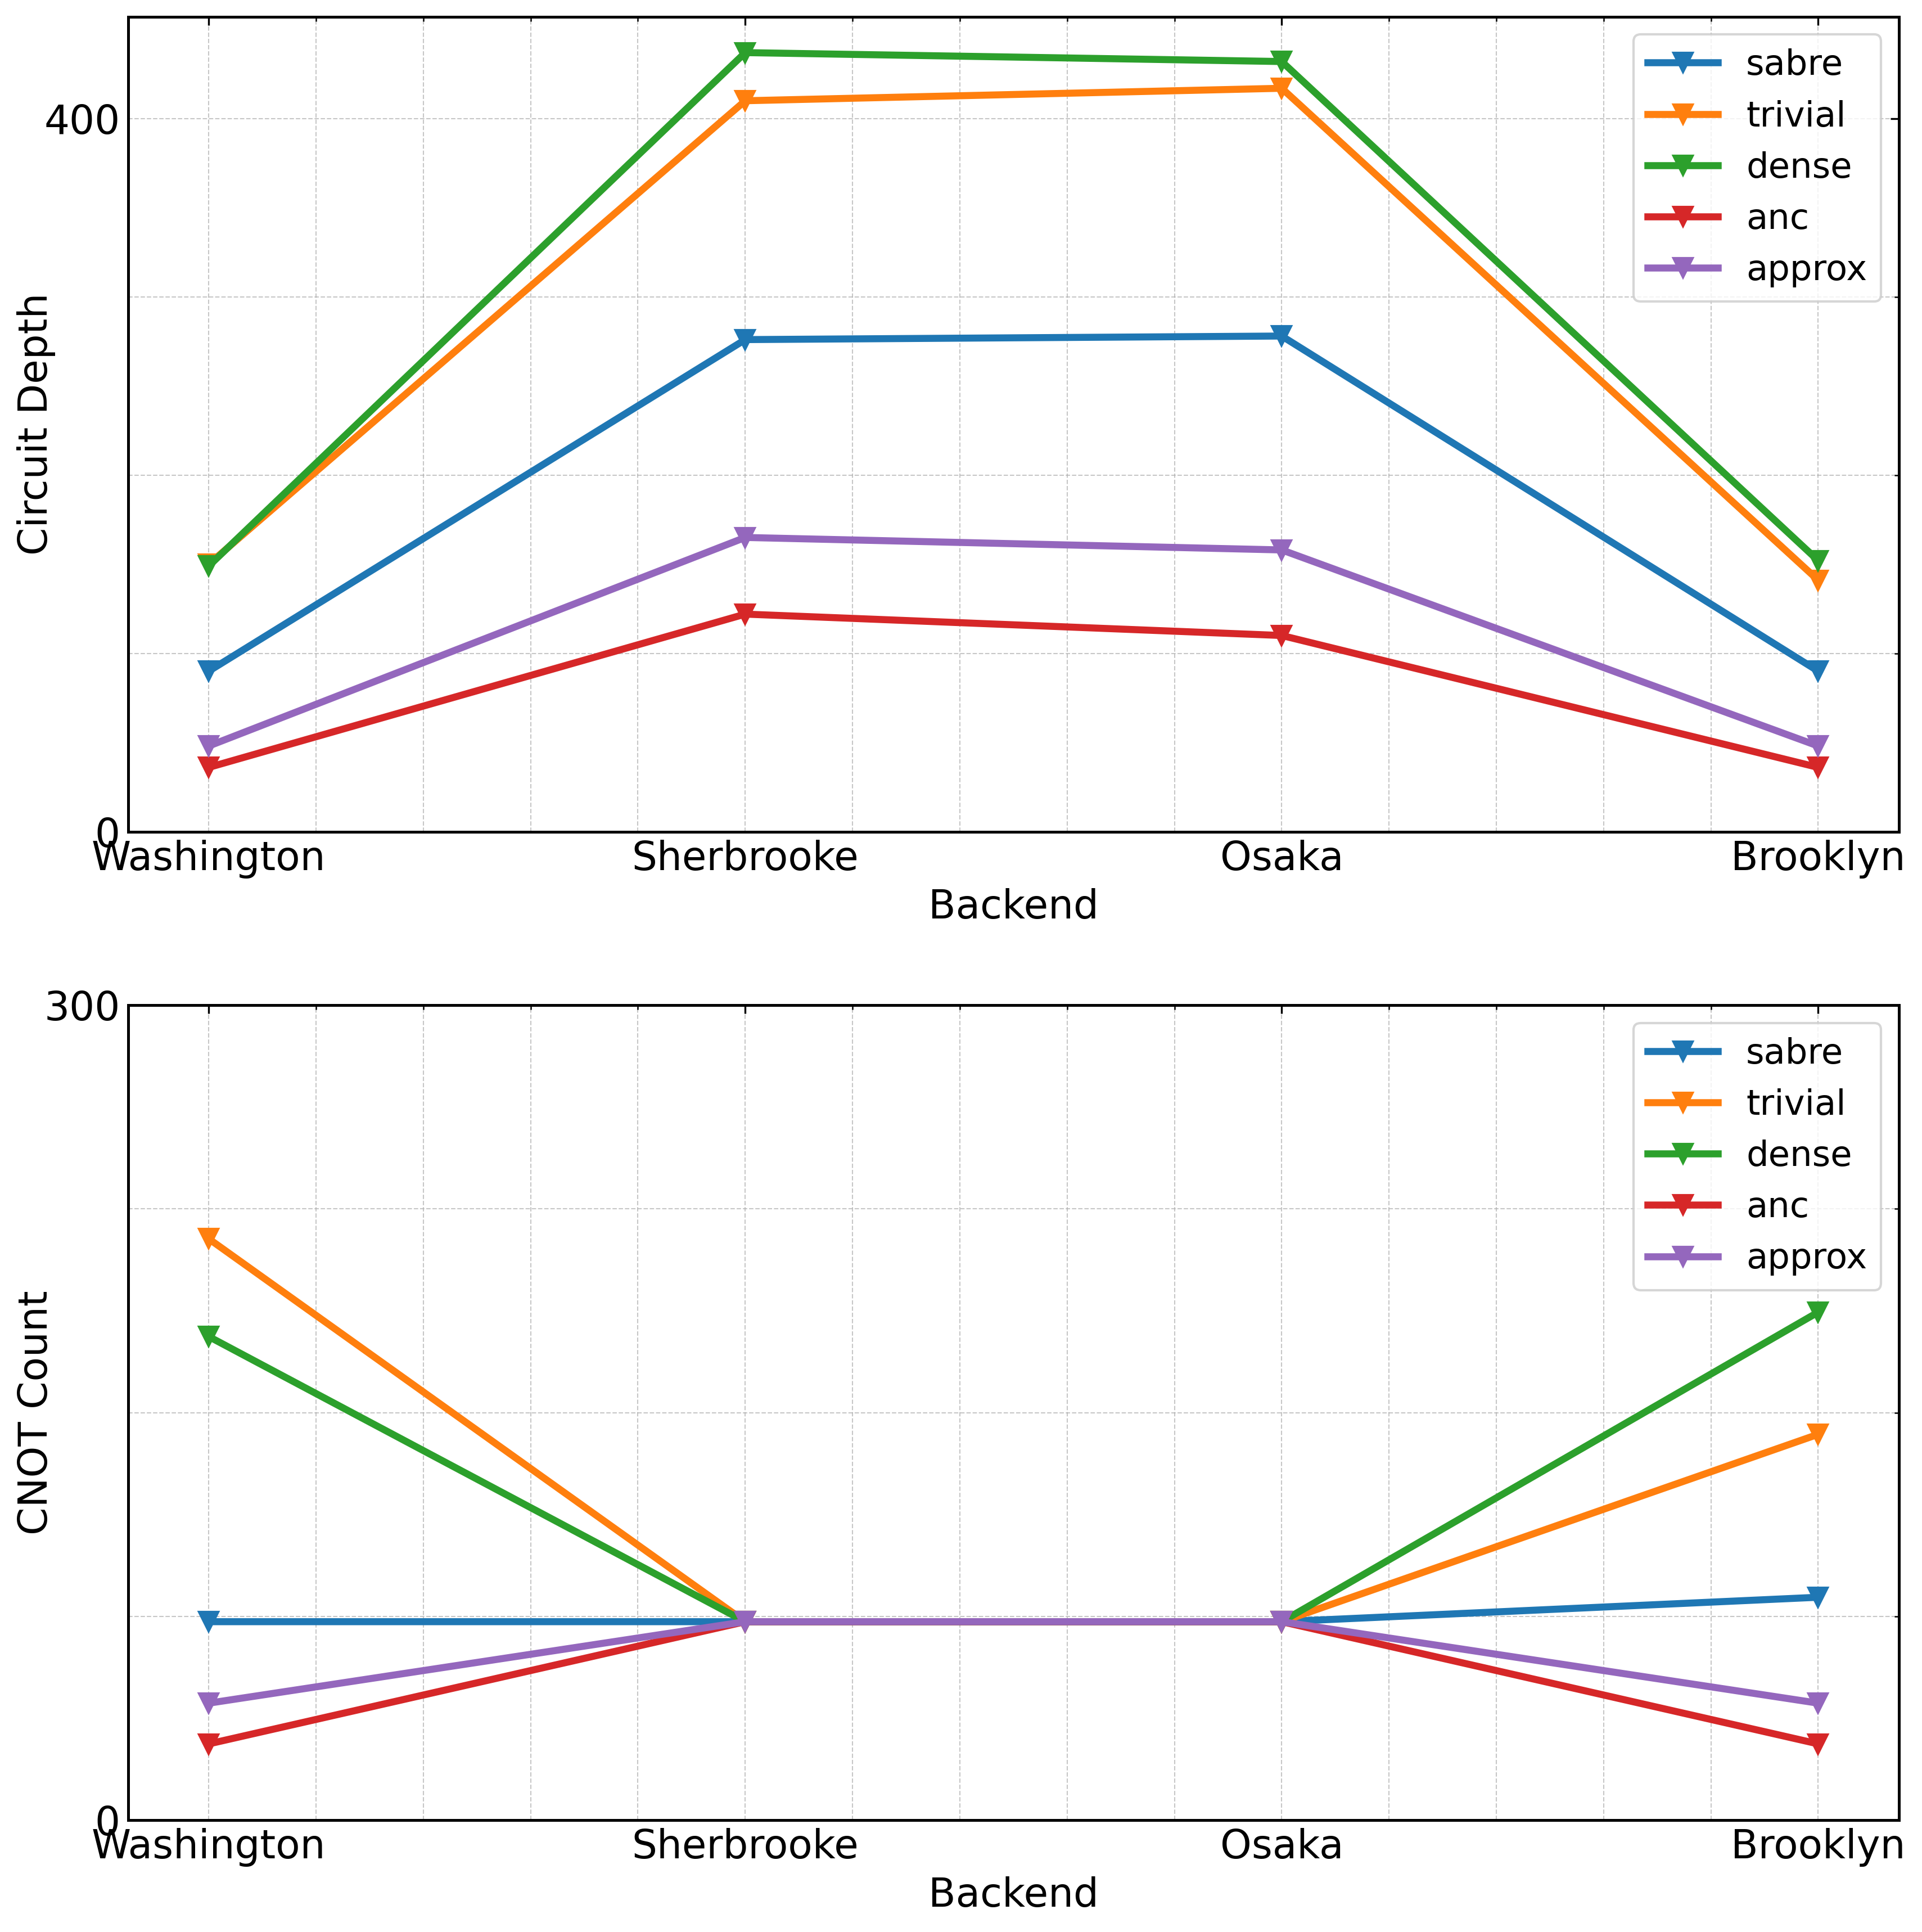

In [130]:
be_s = ["Washington", "Sherbrooke", "Osaka", "Brooklyn"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,12), dpi=300)
ax = axs[0]
ax.plot(be_s, depth_s["sabre"], "v-", label="sabre")
ax.plot(be_s, depth_s["trivial"], "v-", label="trivial")
ax.plot(be_s, depth_s["dense"], "v-", label="dense")
ax.plot(be_s, depth_s["full"], "v-", label="anc")
ax.plot(be_s, depth_s["approx"], "v-", label="approx")
ax.set_xlabel('Backend')
ax.set_ylabel('Circuit Depth', labelpad=-5)
ax.set_yticks(np.array([0, 400]))
ax.legend()

ax = axs[1]
ax.plot(be_s, cnot_s["sabre"], "v-", label="sabre")
ax.plot(be_s, cnot_s["trivial"], "v-", label="trivial")
ax.plot(be_s, cnot_s["dense"], "v-", label="dense")
ax.plot(be_s, cnot_s["full"], "v-", label="anc")
ax.plot(be_s, cnot_s["approx"], "v-", label="approx")
ax.set_xlabel('Backend')
ax.set_ylabel('CNOT Count', labelpad=-5)
ax.set_yticks(np.array([0, 300]))
ax.legend()
plt.tight_layout()

## Generalizing to Disordered Multi-Qubit Gates <a class="anchor" id="generalizing"></a>

Until now, our focus was always on the circuits generated with "RealAmplitudes()" which creates very ordered and sequential set of gates. We will show that with some help of mathematical computation, we can generalize circular mapping.

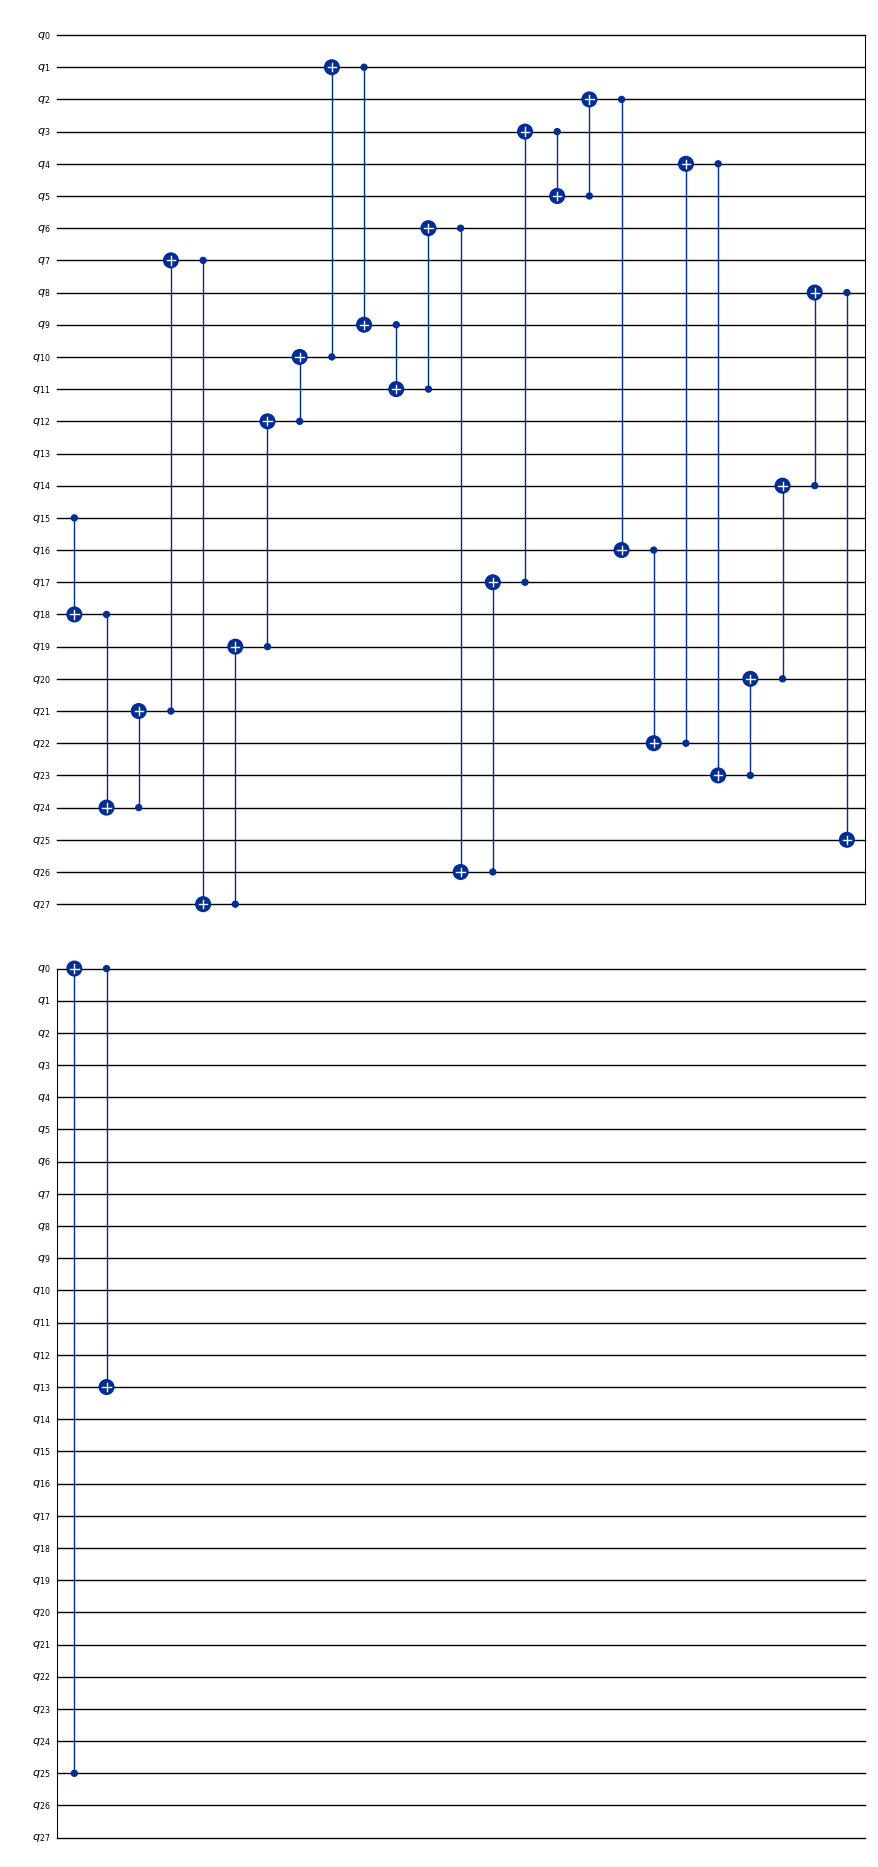

In [131]:
# Create a 28 qubits circuit with sequential but not ordered CX gates
nums = np.arange(28)
dublets = []

# Delete each qubit from the list after a CX gate is connected and assign it for the next CX gate
k = nums[np.random.randint(0,len(nums))]
nums = np.delete(nums,np.where(nums==k))
for i in range(27):
    l = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==l))
    dublets.append((k,l))
    k = l

# Constitute the quantum circuit and apply CX gates
qc = qiskit.QuantumCircuit(28)
for i, j in dublets:
    qc.cx(qc.qubits[i],qc.qubits[j])

qc.draw("mpl", scale=0.5)

In [132]:
n = 28

backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Obtain cycle-graph
cycle = find_best_cycle(cm, n)

# Layout mapping for circular mapping
layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(n)}
layout_cyclic = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for Circular layout
pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

sabre_transpiled_circuit = pass_manager_sabre.run(qc)
circularly_transpiled_circuit = pass_manager_cycle.run(qc)

print("Depth (Sabre | Circle): ", sabre_transpiled_circuit.depth(), " | ", circularly_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", circularly_transpiled_circuit.count_ops().get("cx", 0))

Depth (Sabre | Circle):  135  |  159
CNOT count (Sabre | Circle):  98  |  289


As may be guessed, our method is not succesfful in mapping not ordered circuits. By this, we mean circuits with CX gates in the order of ith qubit to i+1th qubit. However, we can find the order using [OR TOOLS](https://developers.google.com/optimization?hl=tr) and map it to layout

In [133]:
from ortools.sat.python import cp_model

# We are trying to find the ordering of qubits in the way that the distance between CX gates are minimum
def solve_min_cost_2(n, duplets):
    """
    Input:
        n: number of qubits
        duplets: set of qubits of CX gates
    Output:
        result: ordered set of qubits
    """
    model = cp_model.CpModel()

    # Add every possible integer to the model
    x = [model.NewIntVar(0, n - 1, f'x{i}') for i in range(n)]
    model.AddAllDifferent(x)

    cost_terms = []

    # For each duplet calculate the distance, namely cost
    for i, j in duplets:
        if i == j:
            continue  # skip self-loops
        xi, xj = x[i], x[j]
        min_val = model.NewIntVar(0, n - 1, f'min_{i}_{j}')
        max_val = model.NewIntVar(0, n - 1, f'max_{i}_{j}')
        diff = model.NewIntVar(0, n - 1, f'diff_{i}_{j}')

        model.AddMinEquality(min_val, [xi, xj])
        model.AddMaxEquality(max_val, [xi, xj])
        model.Add(diff == max_val - min_val)

        cost_terms.append(diff)

    # Minimize the cost
    total_cost = model.NewIntVar(0, n * (n - 1), 'total_cost')
    model.Add(total_cost == sum(cost_terms))
    model.Minimize(total_cost)

    # Find the optimal solution
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # If there is not error in solver, give the results
    # Order should be argsorted because the result tell us where should be the ordered qubits.
    # For example, first qubit in the physical layout should be the qubit corresponding to the index of 0 on the result
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        result = [solver.Value(xi) for xi in x]
        return np.argsort(result), solver.Value(total_cost)
    else:
        return None, None

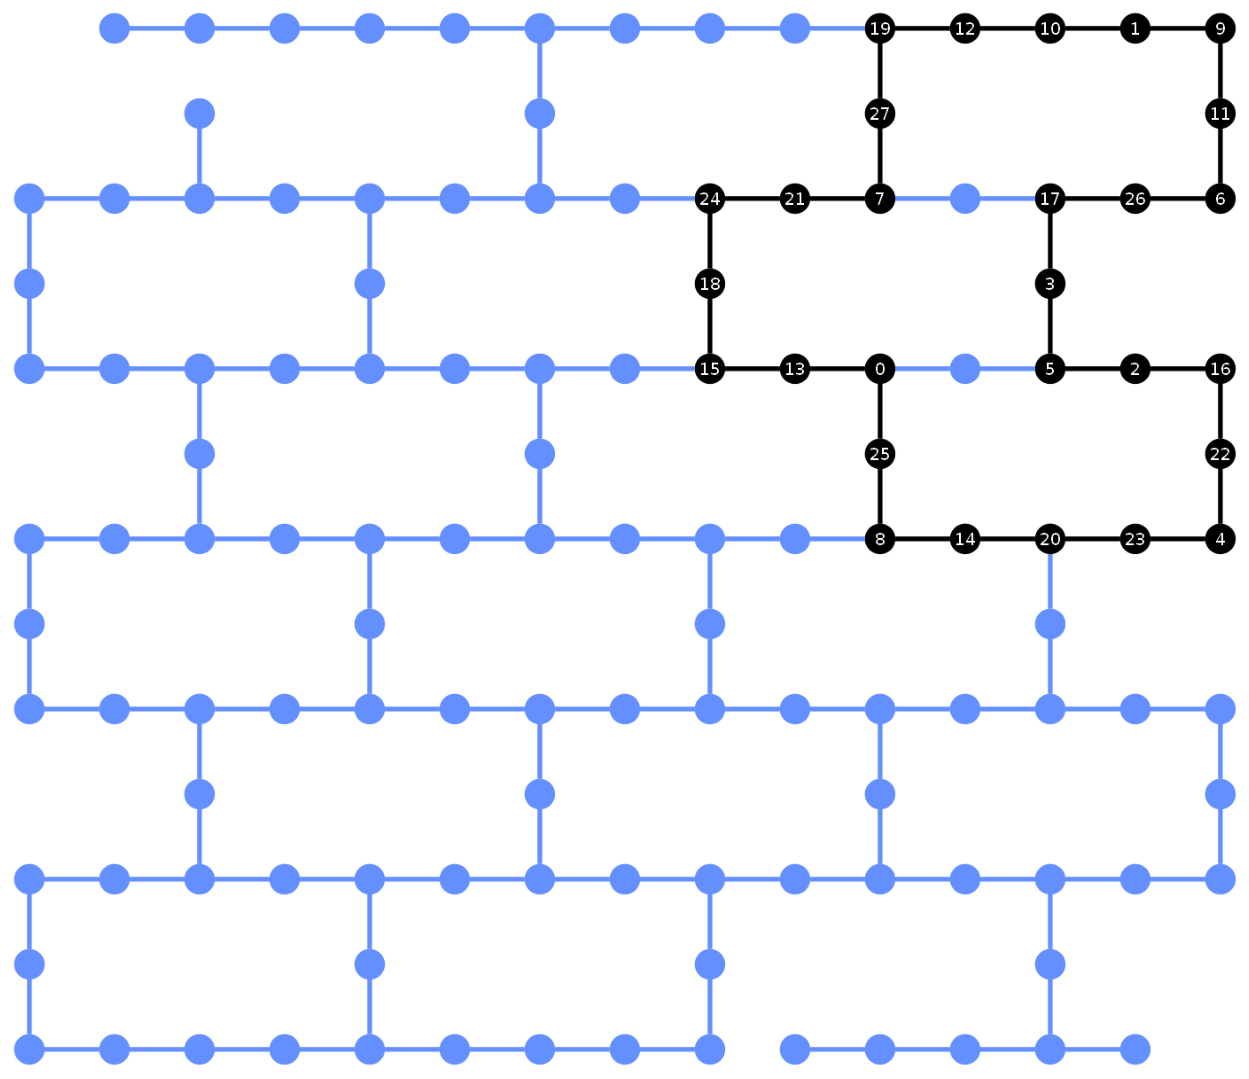

In [134]:
# Calculate the order
order, cost = solve_min_cost_2(28,dublets)

cycle = find_best_cycle(cm, 28)

# Map the qubits
layout_dict = {qc.qubits[order[i]]: cycle[i] for i in range(28)}
layout_cyclic = Layout(layout_dict)


pass_manager = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)
    
reordered_circularly_transpiled_circuit = pass_manager.run(qc)

qiskit.visualization.plot_circuit_layout(reordered_circularly_transpiled_circuit, backend)

As you can see in the layout, qubits are no more connected as 0-1-2 but they are connected in the best way that make the CX distances minimum and reducing the SWAP gates

In [135]:
print("Depth (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.depth(), " | ", circularly_transpiled_circuit.depth(), " | ", reordered_circularly_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", circularly_transpiled_circuit.count_ops().get("cx", 0), " | ", reordered_circularly_transpiled_circuit.count_ops().get("cx",0))

Depth (Sabre | Circle | Reordered Circle):  135  |  159  |  27
CNOT count (Sabre | Circle | Reordered Circle):  98  |  289  |  27


Reordered Circle has a great improvement both in depth and CNOT gate count

For the next step, we further generalize the circuit and instead of sequential CX gates, we apply CX gate to each qubit at least once and more for some of the qubits

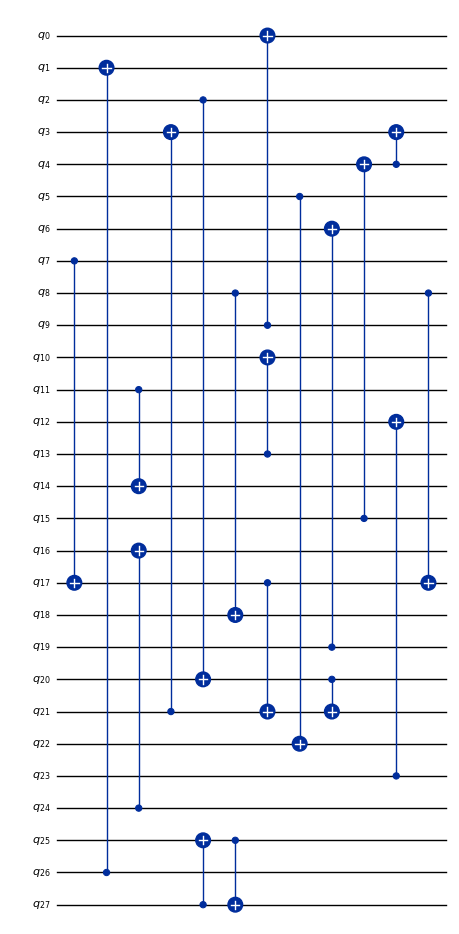

In [ ]:
nums = np.arange(28)
dublets = []

# Apply CX gate to random qubit couples
for i in range(14):
    k = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==k))
    l = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==l))
    dublets.append((k,l))

# Apply additional CX gates to increase disorder
for i in range(5):
    k = np.random.randint(0,28)
    l = np.random.randint(0,28)
    if k != l:
        dublets.append((k,l))

qc = qiskit.QuantumCircuit(28)
for i, j in dublets:
    qc.cx(qc.qubits[i],qc.qubits[j])
qc.draw("mpl", scale=0.5)

In [139]:
n = 28

backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Obtain cycle-graph
cycle = find_best_cycle(cm, n)

# Obtain minimum distance order for qubits
order, cost = solve_min_cost_2(28, dublets)

# Layout mapping for circular mapping
layout_dict = {qc_cyclic.qubits[order[i]]: cycle[i] for i in range(n)}
layout_cyclic = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for Circular layout
pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

sabre_transpiled_circuit = pass_manager_sabre.run(qc)
circularly_transpiled_circuit = pass_manager_cycle.run(qc)

print("Depth (Sabre | Circle): ", sabre_transpiled_circuit.depth(), " | ", circularly_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", circularly_transpiled_circuit.count_ops().get("cx", 0))

Depth (Sabre | Circle):  10  |  9
CNOT count (Sabre | Circle):  37  |  29


In this case, Sabre method is also impressively good yet circular transpilation is still better in terms of CNOT gate count. Nevertheless, it can be estimated that more disorder inserted to the gates, less effective circular method be

As a last example, we try to realize random Toffoli gates and try to reach optimum ordering and conditions. This mapping can be very efficient to imply Grover's Diffusion Operator by simplyifing MCX gate using methods like [Khattar and Gidney, 2025](https://arxiv.org/pdf/2407.17966) which have loop patterns with ancilla qubits

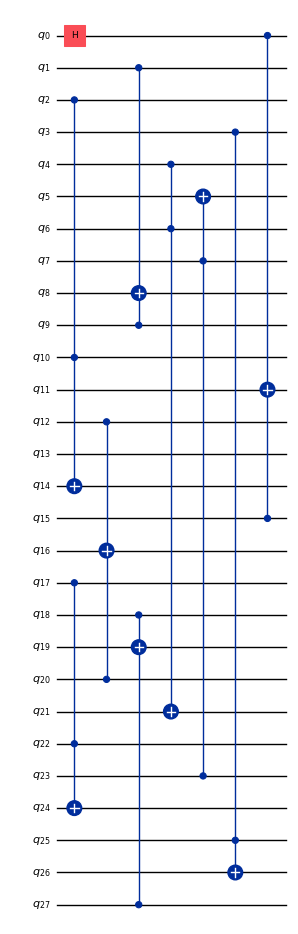

In [140]:
nums = np.arange(28)
triplets = []

# Create random triplets for CCX gate
for i in range(9):
    k = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==k))
    l = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==l))
    m = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==m))
    triplets.append((k,l,m))

qc = qiskit.QuantumCircuit(28)
qc.h(0)
for i, j, x in triplets:
    qc.ccx(qc.qubits[i],qc.qubits[j], qc.qubits[x])

qc.draw("mpl", scale=0.5)

In [141]:
# 3-qubit gate version of distance minimizer
def solve_min_cost_3(n, triplets):
    """
    Input:
        n: number of qubits
        duplets: set of qubits of CX gates
    Output:
        result: ordered set of qubits,
        cost: total distance between gates (normalized by two)
    """
    model = cp_model.CpModel()
    
    x = [model.NewIntVar(0, n-1, f'x{i}') for i in range(n)]
    model.AddAllDifferent(x)

    cost_terms = []

    for i, j, k in triplets:
        xi, xj, xk = x[i], x[j], x[k]

        min_val = model.NewIntVar(0, n-1, f'min_{i}_{j}_{k}')
        max_val = model.NewIntVar(0, n-1, f'max_{i}_{j}_{k}')
        diff = model.NewIntVar(0, n - 1, f'diff_{i}_{j}_{k}')

        # Use AddMinEquality and AddMaxEquality
        model.AddMinEquality(min_val, [xi, xj, xk])
        model.AddMaxEquality(max_val, [xi, xj, xk])
        model.Add(diff == max_val - min_val)

        cost_terms.append(diff)

    total_cost = model.NewIntVar(0, n * (n - 1), 'total_cost')
    model.Add(total_cost == sum(cost_terms))
    model.Minimize(total_cost)

    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        result = [solver.Value(xi) for xi in x]
        return np.argsort(result), solver.Value(total_cost)
    else:
        return None, None

In [142]:
n = 28

backend = qiskit_ibm_runtime.fake_provider.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Obtain cycle-graph
cycle = find_best_cycle(cm, n)

# Obtain minimum distance order for qubits
order, cost = solve_min_cost_3(28, triplets)

# Layout mapping for circular mapping
layout_dict = {qc_cyclic.qubits[order[i]]: cycle[i] for i in range(n)}
layout_cyclic = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for Circular layout
pass_manager_cycle = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        seed_transpiler=SEED)

sabre_transpiled_circuit = pass_manager_sabre.run(qc)
circularly_transpiled_circuit = pass_manager_cycle.run(qc)

print("Depth (Sabre | Circle): ", sabre_transpiled_circuit.depth(), " | ", circularly_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", circularly_transpiled_circuit.count_ops().get("cx", 0))

Depth (Sabre | Circle):  19  |  24
CNOT count (Sabre | Circle):  75  |  103


This shows that Sabre started become more efficient as disorder continues to increase, yet circular transpilation is still competitive enough